In [39]:
# import os
# import logging
# from netCDF4 import Dataset
# from torch.utils.data import Dataset as TorchDataset
# import torch
# import numpy as np

# class NCDataset(TorchDataset):
#     """
#     Dataset for loading NetCDF files.
#     """
#     def __init__(self, input_directory: str, output_directory: str, variable_names: dict, data_fraction: float = 1.0):
#         """
#         :param input_directory: Directory where the input .nc files are stored.
#         :param output_directory: Directory where the output .nc files are stored.
#         :param variable_names: Dictionary of variable names to load from the .nc files. Should have 'input' and 'output' keys.
#         :param data_fraction: Fraction of data files to use (default is 1.0, which means use all files).
#         """
#         self.input_directory = input_directory
#         self.output_directory = output_directory
#         self.variable_names = variable_names
#         self.data_fraction = data_fraction
#         self.input_files = self._load_files(input_directory)
#         self.output_files = self._load_files(output_directory)

#     @staticmethod
#     def load_nc_files(directory: str, variable_name: str, file_index: int):
#         """
#         Load data from a .nc file.

#         :param directory: Directory where the .nc files are stored.
#         :param variable_name: Name of the variable to load from the .nc files.
#         :param file_index: Index of the file to load.
#         :return: Data loaded from the .nc file, or None if an error occurred.
#         """
#         files = os.listdir(directory)
#         files = [f for f in files if f.endswith('.nc')]

#         if not files:
#             logging.error("No .nc files found in the directory.")
#             return None

#         files.sort(key=lambda x: int(x.split('.')[0]))

#         if file_index < 0 or file_index >= len(files):
#             logging.error("file_index is out of range.")
#             return None

#         file_path = os.path.join(directory, files[file_index])

#         try:
#             with Dataset(file_path, 'r') as nc_file:
#                 if variable_name not in nc_file.variables:
#                     logging.error(f"Variable {variable_name} not found in the file.")
#                     return None

#                 data = nc_file.variables[variable_name][:]
#         except Exception as e:
#             logging.error(f"Error reading the .nc file: {str(e)}")
#             return None

#         return data

#     def _load_files(self, directory):
#         """
#         Load the list of .nc files from the directory.

#         :return: Sorted list of .nc files in the directory.
#         """
#         files = os.listdir(directory)
#         files = [f for f in files if f.endswith('.nc')]
#         files.sort(key=lambda x: int(x.split('.')[0]))
        
#         # Only use a fraction of files if specified
#         num_files = int(len(files) * self.data_fraction)
#         files = files[:num_files]
        
#         return files
    
#     def __len__(self):
#         """
#         Get the number of .nc files in the directory.

#         :return: Number of .nc files in the directory.
#         """
#         return len(self.input_files)
    
#     def __getitem__(self, idx: int):
#         inputs = [self.load_nc_files(self.input_directory, var, idx) for var in self.variable_names['input']]
#         outputs = [self.load_nc_files(self.output_directory, var, idx) for var in self.variable_names['output']]
            
#         if any(v is None for v in inputs+outputs):
#             return None

#         inputs = [torch.from_numpy(data) for data in inputs]
#         outputs = [torch.from_numpy(data) for data in outputs]

#         inputs = torch.cat(inputs, dim=1)
#         outputs = torch.cat(outputs, dim=1)

#         if self.input_mean is not None and self.input_std is not None:
#             inputs = self.normalize(inputs, self.input_mean, self.input_std)

#         if self.output_mean is not None and self.output_std is not None:
#             outputs = self.normalize(outputs, self.output_mean, self.output_std)

#         return inputs, outputs

#     def get_means_and_stds(self, indices=None):
#         """
#         Calculate normalization parameters (mean, std) for the dataset.

#         :param indices: List of indices to include in the calculation. If None, use all items.
#         """
#         all_input_data = []
#         all_output_data = []

#         if indices is None:  # If no specific indices are provided, use all items.
#             indices = range(len(self))
        
#         for idx in indices:
#             item = self.__getitem__(idx)
#             if item is not None:  # If __getitem__ returned None due to an error, skip this item.
#                 inputs, outputs = item
#                 all_input_data.append(inputs.numpy())
#                 all_output_data.append(outputs.numpy())

#         # Stack all data
#         all_input_data = np.concatenate(all_input_data, axis=0)
#         all_output_data = np.concatenate(all_output_data, axis=0)
    
#         # Compute mean and std for each channel
#         input_mean = np.mean(all_input_data, axis=(0, 2, 3))
#         input_std = np.std(all_input_data, axis=(0, 2, 3))

#         output_mean = np.mean(all_output_data, axis=(0, 2, 3))
#         output_std = np.std(all_output_data, axis=(0, 2, 3))

#         return input_mean, input_std, output_mean, output_std

#     def normalize(self, inputs, outputs, input_mean, input_std, output_mean, output_std):
#         # Normalize inputs
#         inputs = (inputs - input_mean[None, :, None, None]) / input_std[None, :, None, None]
        
#         # Normalize outputs
#         outputs = (outputs - output_mean[None, :, None, None]) / output_std[None, :, None, None]
        
#         return inputs, outputs





In [1]:
import os
import logging
from netCDF4 import Dataset
from torch.utils.data import Dataset as TorchDataset
import torch
import numpy as np

class NCDataset(TorchDataset):
    """
    Dataset for loading NetCDF files.
    """

    def __init__(self, input_directory: str, output_directory: str, variable_names: dict, data_fraction: float = 1.0):
        """
        :param input_directory: Directory where the input .nc files are stored.
        :param output_directory: Directory where the output .nc files are stored.
        :param variable_names: Dictionary of variable names to load from the .nc files. Should have 'input' and 'output' keys.
        :param data_fraction: Fraction of data files to use (default is 1.0, which means use all files).
        """
        self.input_directory = input_directory
        self.output_directory = output_directory
        self.variable_names = variable_names
        self.data_fraction = data_fraction
        self.input_files = self._load_files(input_directory)
        self.output_files = self._load_files(output_directory)
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None

    @staticmethod
    def load_nc_files(directory: str, variable_name: str, file_index: int):
        """
        Load data from a .nc file.

        :param directory: Directory where the .nc files are stored.
        :param variable_name: Name of the variable to load from the .nc files.
        :param file_index: Index of the file to load.
        :return: Data loaded from the .nc file, or None if an error occurred.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]

        if not files:
            logging.error("No .nc files found in the directory.")
            return None

        files.sort(key=lambda x: int(x.split('.')[0]))

        if file_index < 0 or file_index >= len(files):
            logging.error("file_index is out of range.")
            return None

        file_path = os.path.join(directory, files[file_index])

        try:
            with Dataset(file_path, 'r') as nc_file:
                if variable_name not in nc_file.variables:
                    logging.error(f"Variable {variable_name} not found in the file.")
                    return None

                data = nc_file.variables[variable_name][:]
        except Exception as e:
            logging.error(f"Error reading the .nc file: {str(e)}")
            return None

        return data

    def _load_files(self, directory):
        """
        Load the list of .nc files from the directory.

        :return: Sorted list of .nc files in the directory.
        """
        files = os.listdir(directory)
        files = [f for f in files if f.endswith('.nc')]
        files.sort(key=lambda x: int(x.split('.')[0]))
        
        # Only use a fraction of files if specified
        num_files = int(len(files) * self.data_fraction)
        files = files[:num_files]
        
        return files

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx: int):
        inputs = [self.load_nc_files(self.input_directory, var, idx) for var in self.variable_names['input']]
        outputs = [self.load_nc_files(self.output_directory, var, idx) for var in self.variable_names['output']]

        if any(v is None for v in inputs+outputs):
            return None

        inputs = [torch.from_numpy(data) for data in inputs]
        outputs = [torch.from_numpy(data) for data in outputs]

        inputs = torch.cat(inputs, dim=1)
        outputs = torch.cat(outputs, dim=1)

        if self.input_mean is not None and self.input_std is not None:
            inputs = self.normalize(inputs, self.input_mean, self.input_std)

        if self.output_mean is not None and self.output_std is not None:
            outputs = self.normalize(outputs, self.output_mean, self.output_std)

        return inputs, outputs

    def get_means_and_stds(self, indices):
        all_input_data = [self.__getitem__(idx)[0] for idx in indices]
        all_output_data = [self.__getitem__(idx)[1] for idx in indices]
        
        input_mean = torch.mean(torch.cat(all_input_data, axis=0), axis=(0, 2, 3))
        input_std = torch.std(torch.cat(all_input_data, axis=0), axis=(0, 2, 3))

        output_mean = torch.mean(torch.cat(all_output_data, axis=0), axis=(0, 2, 3))
        output_std = torch.std(torch.cat(all_output_data, axis=0), axis=(0, 2, 3))

        return input_mean, input_std, output_mean, output_std

    def normalize(self, data, mean, std):
        return (data - mean[None, :, None, None]) / std[None, :, None, None]


/home/exouser/anaconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Create a dataset
x_train_path = '/media/volume/sdc/data_qg/3jet/'
y_train_path = '/media/volume/sdc/data_qg/3jet/'
nc_dataset = NCDataset(x_train_path, y_train_path, {'input': ['u', 'v'], 'output': ['q']}, data_fraction=0.01)

# 2. Define the size of each split
train_fraction = 0.8  # 80% of the data for training
val_fraction = 0.1  # 10% of the data for validation
test_fraction = 0.1  # 10% of the data for testing

# 3. Calculate the number of samples for each split
num_samples = len(nc_dataset)
train_end = int(num_samples * train_fraction)
val_end = train_end + int(num_samples * val_fraction)

# 4. Split the dataset
train_dataset = torch.utils.data.Subset(nc_dataset, range(0, train_end))
val_dataset = torch.utils.data.Subset(nc_dataset, range(train_end, val_end))
test_dataset = torch.utils.data.Subset(nc_dataset, range(val_end, num_samples))


In [6]:
input_mean_train, input_std_train, output_mean_train, output_std_train = train_dataset.dataset.get_means_and_stds(indices=train_dataset.indices)

# Get the mean std of the training set
train_dataset.dataset.input_mean = input_mean_train
train_dataset.dataset.input_std = input_std_train
train_dataset.dataset.output_mean = output_mean_train
train_dataset.dataset.output_std = output_std_train
input_mean, input_std, output_mean, output_std = train_dataset.dataset.get_means_and_stds(indices=train_dataset.indices)
print(input_mean, input_std, output_mean, output_std)

# Get the mean std of the test set
test_dataset.dataset.input_mean = None
test_dataset.dataset.input_std = None
test_dataset.dataset.output_mean = None
test_dataset.dataset.output_std = None
input_mean, input_std, output_mean, output_std = test_dataset.dataset.get_means_and_stds(indices=test_dataset.indices)
print(input_mean, input_std, output_mean, output_std)

val_dataset.dataset.input_mean = input_mean_train
val_dataset.dataset.input_std = input_std_train
val_dataset.dataset.output_mean = output_mean_train
val_dataset.dataset.output_std = output_std_train
# Get the mean std of the validation set
input_mean, input_std, output_mean, output_std = val_dataset.dataset.get_means_and_stds(indices=val_dataset.indices)
print(input_mean, input_std, output_mean, output_std)




tensor([ 9.0141e-11, -6.8345e-11, -8.7513e-11,  6.4728e-11]) tensor([1., 1., 1., 1.]) tensor([3.6936e-08, 6.3523e-11]) tensor([1.0000, 1.0000])
tensor([ 2.0506e-12, -6.8968e-13,  2.9620e-12,  1.3079e-12]) tensor([0.0290, 0.0062, 0.0335, 0.0056]) tensor([5.3936e-07, 2.1702e-17]) tensor([6.7794e-06, 1.2883e-07])
tensor([ 3.0132e-11, -8.1542e-11, -3.3954e-11, -5.1433e-12]) tensor([0.9553, 0.9606, 0.9745, 0.9863]) tensor([ 3.1148e-04, -7.8761e-11]) tensor([0.9676, 0.9779])


In [40]:
# 2.8 Use the dataset with a DataLoader
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
data_loader_validation = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [41]:
for i, (inputs, outputs) in enumerate(data_loader_train):
    # print(inputs.shape, outputs.shape)
    
    # print the stats of the first batch
    if i == 0:
        print(inputs[0].mean(axis= (0, 2, 3)), inputs[0].std(axis= (0, 2, 3)))

tensor([-9.1768e-11, -2.3444e-10, -5.3340e-10,  8.0119e-10]) tensor([0.7806, 0.7141, 0.8677, 0.8374])


In [42]:
# Get the mean std of the training set
train_dataset.dataset.input_mean = None
train_dataset.dataset.input_std = None
train_dataset.dataset.output_mean = None
train_dataset.dataset.output_std = None
input_mean, input_std, output_mean, output_std = train_dataset.dataset.get_means_and_stds(indices=train_dataset.indices)
print(input_mean, input_std, output_mean, output_std)

tensor([-1.5845e-12, -1.5407e-13, -4.5264e-12,  1.7764e-15]) tensor([0.0289, 0.0061, 0.0321, 0.0053]) tensor([5.4491e-07, 6.0045e-18]) tensor([6.6005e-06, 1.2427e-07])


In [43]:
for i, (inputs, outputs) in enumerate(data_loader_train):
    # print(inputs.shape, outputs.shape)
    
    # print the stats of the first batch
    if i == 0:
        print(inputs[0].mean(axis= (0, 2, 3)), inputs[0].std(axis= (0, 2, 3)))

tensor([-6.8034e-12, -1.9528e-12,  2.4201e-11,  2.7919e-12]) tensor([0.0225, 0.0044, 0.0279, 0.0045])


# Showing 2D activations


## Utils

In [2]:
# Loading pickle file
import pickle
with open('activation_dict.pkl', 'rb') as f:
    loaded_activation = pickle.load(f)

def get_activation(activation_dict, layer_name="output", epoch=-1, sample=0, channel=0):
    return activation_dict[layer_name][epoch, sample, channel]



## Plotting fft2 of activations

(64, 64)


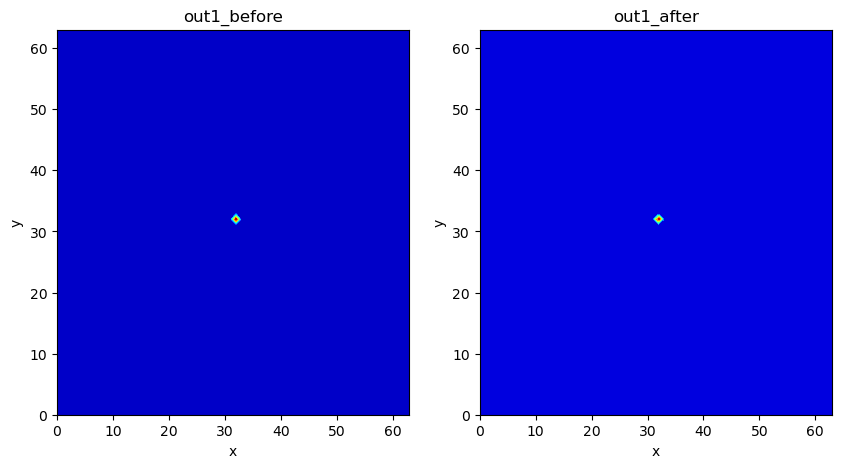

In [10]:
# Plot the fft2 of out1_before
out1_before = get_activation(loaded_activation, 'output', epoch=-1, sample=0, channel=0)
out1_after = get_activation(loaded_activation, 'out1_after', epoch= -1, sample= 0, channel= 1)

print(out1_before.shape)

import matplotlib.pyplot as plt
import numpy as np

out1_before_fft2 = np.abs(np.fft.fftshift(np.fft.fft2(out1_before)))
out1_after_fft2 = np.abs(np.fft.fftshift(np.fft.fft2(out1_after)))

# Subplot contourf before and after
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(out1_before_fft2, cmap='jet')
axs[0].set_title('out1_before')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

axs[1].set_title('out1_after')
axs[1].contourf(out1_after_fft2, cmap='jet')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
plt.show()



# Playing with weights

In [39]:
# Load weight 
import pickle

def get_kernel(weights, layer_index=0, input_channel_index=0, output_channel_index=0):
    return weights[layer_index][output_channel_index, input_channel_index]

with open('weights_dict.pkl', 'rb') as f:
    loaded_weight = pickle.load(f)


In [33]:
def initialize_wavenumbers_2DFHIT(nx, ny, Lx, Ly):
    '''
    Initialize the wavenumbers for 2D Forced Homogeneous Isotropic Turbulence (2D-FHIT).
    
    Parameters:
    -----------
    nx : int
        Number of grid points in the x-direction.
    ny : int
        Number of grid points in the y-direction.
    Lx : float
        Length of the domain in the x-direction.
    Ly : float
        Length of the domain in the y-direction.

    Returns:
    --------
    Kx : numpy.ndarray
        2D array of wavenumbers in the x-direction.
    Ky : numpy.ndarray
        2D array of wavenumbers in the y-direction.
    Ksq : numpy.ndarray
        2D array of the square of the wavenumber magnitudes.
    '''
    kx = 2 * np.pi * np.fft.fftfreq(nx, d=Lx/nx)
    ky = 2 * np.pi * np.fft.fftfreq(ny, d=Ly/ny)
    (Kx, Ky) = np.meshgrid(kx, ky, indexing='ij')
    Ksq = Kx ** 2 + Ky ** 2
    return Kx, Ky, Ksq


In [80]:

# -------------- Geometry and mesh Calculation --------------
# Number of grid points in each direction
NX = 64

# Domain length
Lx = 2 * np.pi

# Mesh size
dx = Lx / NX

# Mesh points in x direction
x = np.linspace(0, Lx - dx, num=NX)

Kx, Ky, Ksq = initialize_wavenumbers_2DFHIT(NX, NX, Lx, Lx)


# Preparing Kernel for plotting

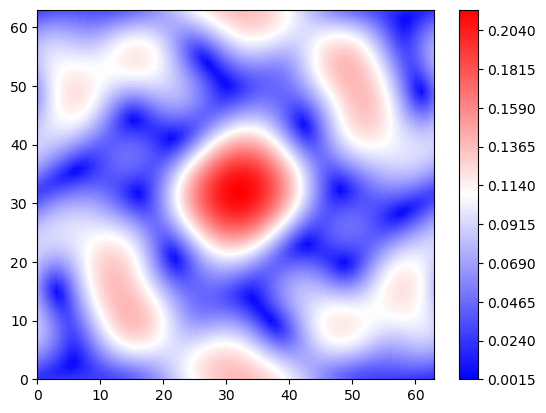

In [85]:
w = get_kernel(loaded_weight, layer_index=1, input_channel_index=6, output_channel_index=1)

# 
w_fft2 = np.abs(np.fft.fftshift(np.fft.fft2(w, s=[NX, NX])))

import matplotlib.pyplot as plt

#Plot the fft2 of kernel
cont = plt.contourf( w_fft2, cmap='bwr', levels=200) 
plt.colorbar()
plt.show()





Working on the 2D spectra of output

In [94]:
# Load .nc file 
import netCDF4 as nc
path = 'output.nc'

# Read the file
data = nc.Dataset(path, 'r')

print(data.variables.keys())

print(data['inputs'].shape)
print(data['true'].shape)
print(data['prediction'].shape)

# close the file
data.close()

dict_keys(['prediction', 'true', 'inputs'])
(174, 4, 64, 64)
(174, 2, 64, 64)
(174, 2, 64, 64)
